# ML: Predicting Star Ratings


Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a data set of venue popularities provided by Yelp.  The data set contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. This tutorial will walk you through one way to build a machine-learning algorithm.


## Import data

In [5]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In Scikit Learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features.  Let's get in this habit now, by creating a separate list of the ratings:

In [6]:
star_ratings = [row['stars'] for row in data]

In [11]:
data[0]

{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA',
 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'},
  'Friday': {'close': '17:00', 'open': '08:00'},
  'Monday': {'close': '17:00', 'open': '08:00'},
  'Wednesday': {'close': '17:00', 'open': '08:00'},
  'Thursday': {'close': '17:00', 'open': '08:00'}},
 'open': True,
 'categories': ['Doctors', 'Health & Medical'],
 'city': 'Phoenix',
 'review_count': 7,
 'name': 'Eric Goldberg, MD',
 'neighborhoods': [],
 'longitude': -111.983758,
 'state': 'AZ',
 'stars': 3.5,
 'latitude': 33.499313,
 'attributes': {'By Appointment Only': True},
 'type': 'business'}

In [12]:
star_ratings[0]

3.5

In [11]:
d={}
d_count={}
for city,star in zip(data,star_ratings):
    d[city['city']]=d.get(city['city'],0)+star
    d_count[city['city']]=d_count.get(city['city'],0)+1

## city_avg

### Get average stars for each citiy

In [12]:
avg_stars = {}
for city in d.keys():
    avg_stars[city]=(d[city]/d_count[city])
avg_stars

{'Phoenix': 3.6702903946388683,
 'De Forest': 3.75,
 'Mc Farland': 3.1,
 'Middleton': 3.611111111111111,
 'Madison': 3.6457337883959045,
 'Sun Prairie': 3.455223880597015,
 'Windsor': 3.5,
 'Monona': 3.4727272727272727,
 'Chandler': 3.667574931880109,
 'Scottsdale': 3.8206757594544327,
 'Tempe': 3.644621295279912,
 'Florence': 3.6176470588235294,
 'Peoria': 3.6388367729831144,
 'Glendale': 3.607404021937843,
 'Cave Creek': 3.9122137404580153,
 'Paradise Valley': 3.6690140845070425,
 'Mesa': 3.5901461829994585,
 'Ahwatukee': 3.6875,
 'Pheonix': 3.0,
 'Anthem': 3.7818181818181817,
 'Gilbert': 3.752396166134185,
 'Gold Canyon': 3.5,
 'Apache Junction': 3.6375,
 'Goldfield': 3.5,
 'Casa Grande': 3.5172413793103448,
 'Coolidge': 3.4375,
 'Higley': 3.5,
 'Queen Creek': 3.6456043956043955,
 'Sun Lakes': 3.2222222222222223,
 'Goodyear': 3.5313653136531364,
 'Fort Mcdowell': 4.0,
 'Fountain Hills': 3.7904761904761903,
 'Fountain Hls': 3.0,
 'Maricopa': 3.52,
 'chandler': 5.0,
 'Buckeye': 3.4084

There should be 167 different cities:

In [22]:
assert len(avg_stars) == 167

## city_model: building a model to predict city average

In [176]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, star_ratings, test_size=0.20)

In [19]:
from sklearn import base
import numpy as np

class CityEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
        
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        df=pd.DataFrame.from_dict(X, orient='columns')
        self.mean = np.mean(df['stars'],axis=0)
        try:
            self.avg_stars=df.groupby('city')['stars'].mean()
        except:
            self.avg_stars={}
        return self
    
    def predict(self, X):
        try:
            return [self.avg_stars[row['city']] for row in X]
        except:
            return [self.mean]*1200

Now we can create an instance of our estimator and train it.

In [293]:
city_est = CityEstimator()
city_est.fit(X_train, y_train)

CityEstimator()

And let's see if it works.

In [294]:
avg_stars[data[4]['city']]

3.5901461829994585

In [295]:
city_est.predict(data[:5])

[3.651790294449574,
 3.658536585365854,
 3.644716692189893,
 3.825718241606092,
 3.5924924924924926]

## lat_long_model: extract features from coordinator

### using column selector

In [400]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        #df=pd.DataFrame.from_dict(X, orient='columns')
        return [[row[col] for col in self.col_names] for row in X]

In [401]:
[[row['latitude'],row['longitude']] for row in data[:1]]

[[33.4986286, -111.9224398]]

Let's test it on a single row, just as a sanity check:

In [402]:
cst = ColumnSelectTransformer(['latitude', 'longitude'])
assert (cst.fit_transform(data[:1])
        == [[data[0]['latitude'], data[0]['longitude']]])

Now, let's feed the output of the transformer in to a `sklearn.neighbors.KNeighborsRegressor`.  As a sanity check, we'll test it with the first 5 rows.  To truly judge the performance, we'd need to make a test/train split.

In [403]:
from sklearn.neighbors import KNeighborsRegressor

data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

array([4.7, 4.7, 4.2, 3.6, 3.4])

Instead of doing this by hand, let's make a pipeline.  Remember that a pipeline is made with a list of (name, transformer-or-estimator) tuples. 

In [404]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
        # ColumnSelectTransformer
    ('ColumnSel',cst),
        # KNeighborsRegressor    
    ('knn',knn)
    ])

This should work the same way.

In [405]:
pipe.fit(X_train, y_train)
pipe.predict(test_data)

array([4.7, 4.7, 4.3, 3.6, 3.5])

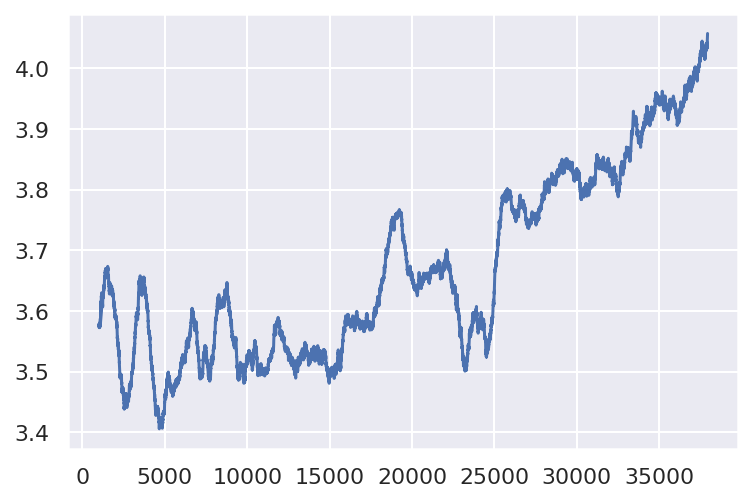

In [154]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean())

### shuffle the data and tun the hyperparameter for KNN

In [396]:
from sklearn.utils import shuffle
data,star_ratings=shuffle(data,star_ratings)
X_train, X_test, y_train, y_test = train_test_split(data,star_ratings, test_size=0.10,random_state=0)

In [32]:
X=np.array(cst.fit_transform(data))
y=np.array(star_ratings)

In [34]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
clf = KNeighborsRegressor()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(clf, cst.fit_transform(data), star_ratings, cv=cv)

array([-0.10012823, -0.1097911 , -0.12143911, -0.10627056, -0.11755551])

In [37]:
cv_test_errors = []
n_neighbors=range(20,30)
indices = np.random.permutation(range(len(y)))
indices
X_random_order, y_random_order = X[indices], y[indices]

In [38]:
for neigh in n_neighbors:
    est = KNeighborsRegressor(n_neighbors=neigh)
    
    # Note that cross_val_score performs K-fold Cross Validation but returns a score,
    # which is the negative of the error.
    cv_test_error = -model_selection.cross_val_score(
        est,
        X_random_order,
        y_random_order,
        cv=5,  # Number of folds
        scoring='neg_mean_squared_error'
    )
    cv_test_errors.append(cv_test_error.mean())

In [39]:
cv_test_errors

[0.7847662888215903,
 0.7834476317793039,
 0.7821580394758155,
 0.7809675824838282,
 0.7801539220924038,
 0.7793159459884041,
 0.7792012602268579,
 0.7783260478267534,
 0.7775884109756575,
 0.7769186859738985]

In [40]:
from sklearn import model_selection

est = KNeighborsRegressor()
gs = model_selection.GridSearchCV(
    est,
    {"n_neighbors": range(19,50)},
    cv=5,  # 5-fold cross validation
    n_jobs=2,  # run each hyperparameter in one of two parallel jobs
    scoring='neg_mean_squared_error'
)
gs.fit(X_random_order, y_random_order)
print (gs.best_params_)


{'n_neighbors': 47}


In [406]:
knn = KNeighborsRegressor(n_neighbors=47)

In [407]:
lat_long_est = Pipeline([
        # ColumnSelectTransformer
    ('ColumnSel',cst),
        # KNeighborsRegressor    
    ('knn',knn)
    ])

In [408]:
lat_long_est.fit(X_train, y_train)
lat_long_est.predict(X_test)

array([3.5       , 3.60638298, 4.06382979, ..., 3.87234043, 4.03191489,
       3.77659574])

## category_model: feature extraction for categorical variables

In [56]:
lis= [row['categories'] for row in data]
lis

[['Department Stores', 'Fashion', 'Shopping'],
 ['Hobby Shops', 'Shopping', 'Toy Stores'],
 ['Hotels & Travel', 'Car Rental'],
 ['Hobby Shops', 'Electronics', 'Shopping'],
 ['French', 'Restaurants'],
 ['Auto Repair', 'Automotive'],
 ['Mexican', 'Restaurants'],
 ['Local Services', 'Home Cleaning', 'Home Services', 'Carpet Cleaning'],
 ['Barbeque', 'Restaurants'],
 ['Food', 'Food Trucks'],
 ['Bakeries', 'Food'],
 ['Pizza', 'Restaurants'],
 ['Home Services', 'Real Estate', 'Apartments'],
 ['Local Services', 'Shipping Centers', 'Notaries', 'Printing Services'],
 ["Men's Clothing", 'Fashion', 'Shopping'],
 ['Veterinarians', 'Pets'],
 ['Home Services', 'Real Estate', 'Apartments'],
 ["Women's Clothing", 'Fashion', 'Shopping'],
 ['Education', 'Preschools'],
 ['Home Services', 'Home Inspectors'],
 ['Seafood', 'Steakhouses', 'Restaurants'],
 ['American (Traditional)', 'Fast Food', 'Restaurants'],
 ['Auto Repair', 'Automotive'],
 ['Automotive', 'Auto Parts & Supplies'],
 ['Active Life', 'Leisure

## use DictVectorizer

In [58]:
from sklearn.feature_extraction import DictVectorizer
v=DictVectorizer(sparse=False)
D=v.fit_transform(l)
D

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [317]:
X=[[['a']], [['b', 'c']]]

In [307]:
s=[]
#d[X[0][0][0]]=1
#d
lis=[el[0] for el in X]
for i in lis:
    d=dict()
    for li in i:
        d[li]=1
    s.append(d)
s

[{'a': 1}, {'b': 1, 'c': 1}]

In [53]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.
        s=[]
        for i in [el[0] for el in X]:
            d=dict()
            for li in i:
                d[li]=1
            s.append(d)
        return s       

That should allow this to pass:

In [959]:
assert (DictEncoder().fit_transform([[['a']], [['b', 'c']]])
        == [{'a': 1}, {'b': 1, 'c': 1}])

Set up a pipeline with your `ColumnSelectTransformer`, your `DictEncoder`, the `DictVectorizer`, and a regularized linear model, like `Ridge`, as the estimator.  This model will have a large number of features, one for each category, so there is a significant danger of overfitting.  Use cross validation to choose the best regularization parameter.

In [49]:
from sklearn.linear_model import Ridge
cst = ColumnSelectTransformer(['categories'])
de=DictEncoder().fit_transform(cst.fit_transform(data))

In [ ]:
dv=DictVectorizer(sparse=False).fit_transform(de)

In [329]:
dv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Build a pipeline, using GridSearchCV for a Ridge model

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data, star_ratings, test_size=0.20)

In [84]:
from sklearn.linear_model import Ridge
clf=Ridge()

In [125]:
category_model = Pipeline([
        # ColumnSelectTransformer
    ('ColumnSel',ColumnSelectTransformer(['categories'])),
     ####DictEncoder
    ('dicten',DictEncoder()),
    ###DictVectorizer
    ('DV',DictVectorizer(sparse=False)),
        # RidgeRegressor    
    ('estimator',GridSearchCV(Ridge(),
                              param_grid={'alpha': [0.01,0.1,1]},
                              refit=True))   
    ])

In [126]:
category_model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ColumnSel',
                 ColumnSelectTransformer(col_names=['categories'])),
                ('dicten', DictEncoder()),
                ('DV',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=False)),
                ('estimator',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001),
                              iid='deprecated', n_jobs=None,
                              param_grid={'alpha': [0.01, 0.1, 1]},
                              pre_dispatch='2*n_jobs', refit=True,
                              return_train

In [414]:
category_model['estimator'].best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [127]:
category_model.predict

<function sklearn.pipeline.Pipeline.predict(self, X, **predict_params)>

## attribute_model: more feature extractions from attributes

In [343]:
data[0]['attributes'].items()

dict_items([('Take-out', True), ('Wi-Fi', 'no'), ('Good For', {'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'breakfast': False, 'brunch': False}), ('Caters', False), ('Noise Level', 'average'), ('Takes Reservations', False), ('Has TV', False), ('Delivery', False), ('Ambience', {'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': True}), ('Parking', {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}), ('Wheelchair Accessible', True), ('Outdoor Seating', True), ('Attire', 'casual'), ('Alcohol', 'none'), ('Waiter Service', False), ('Accepts Credit Cards', True), ('Good for Kids', True), ('Good For Groups', True), ('Price Range', 1)])

In [130]:
lis= [row['attributes'] for row in data]
lis

[{'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': True,
   'valet': False},
  'Accepts Credit Cards': True,
  'Wheelchair Accessible': True,
  'Price Range': 2},
 {'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': False,
   'valet': False},
  'Price Range': 4},
 {},
 {'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': False,
   'valet': False}},
 {'Alcohol': 'full_bar',
  'Takes Reservations': True,
  'Delivery': False,
  'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': False,
   'valet': False},
  'Good For': {'dessert': False,
   'latenight': False,
   'lunch': False,
   'dinner': False,
   'brunch': False,
   'breakfast': False},
  'Attire': 'casual',
  'Waiter Service': True,
  'Wheelchair Accessible': True,
  'Good For Kids': True,
  'Good For Groups': True,
  'Price Range': 2},
 {},
 {'Take-out': True,
  'Wi-Fi': 'no',
  'Good For': {'dessert': False,


In [352]:
data[0]['attributes']['Take-out'] == True

True

In [131]:
attr=[]
#yes=['True','loud', 'very_loud', 'yes_corkage','yes_free', 'free']
#no=['False', 'average', 'no', 'quiet']
for el in data:
    d={}
    for k,v in el['attributes'].items():        
        if (v == True) or (v == 'free'):
        #if v is in yes:
            d[k] = 1
        elif (v == False) or (v == 'no'):
            d[k] = 0 
        else:
            try:
                for k1,v1 in v.items():
                    if v1 == True:
                        d[k+" "+k1] = 1
                    elif (v1 == False) or (v1 == 'no'):
                        d[k+" "+k1] = 0
            except:
                d[k+" "+str(v)] = 1
    attr.append(d)
attr

[{'Parking garage': 0,
  'Parking street': 0,
  'Parking validated': 0,
  'Parking lot': 1,
  'Parking valet': 0,
  'Accepts Credit Cards': 1,
  'Wheelchair Accessible': 1,
  'Price Range 2': 1},
 {'Parking garage': 0,
  'Parking street': 0,
  'Parking validated': 0,
  'Parking lot': 0,
  'Parking valet': 0,
  'Price Range 4': 1},
 {},
 {'Parking garage': 0,
  'Parking street': 0,
  'Parking validated': 0,
  'Parking lot': 0,
  'Parking valet': 0},
 {'Alcohol full_bar': 1,
  'Takes Reservations': 1,
  'Delivery': 0,
  'Parking garage': 0,
  'Parking street': 0,
  'Parking validated': 0,
  'Parking lot': 0,
  'Parking valet': 0,
  'Good For dessert': 0,
  'Good For latenight': 0,
  'Good For lunch': 0,
  'Good For dinner': 0,
  'Good For brunch': 0,
  'Good For breakfast': 0,
  'Attire casual': 1,
  'Waiter Service': 1,
  'Wheelchair Accessible': 1,
  'Good For Kids': 1,
  'Good For Groups': 1,
  'Price Range 2': 1},
 {},
 {'Take-out': 1,
  'Wi-Fi': 0,
  'Good For dessert': 0,
  'Good F

In [132]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        #df=pd.DataFrame.from_dict(X, orient='columns')
        return [[row[col] for col in self.col_names] for row in X]
    
cst = ColumnSelectTransformer(['attributes'])
attributes=cst.fit_transform(data)
attributes[1],attributes[1][0]

([{'Parking': {'garage': False,
    'street': False,
    'validated': False,
    'lot': False,
    'valet': False},
   'Price Range': 4}],
 {'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': False,
   'valet': False},
  'Price Range': 4})

In [133]:
class FlattenTransformer(base.BaseEstimator, base.RegressorMixin):
    #Class Constructor 
    def __init__(self):
        self.attr = []
    
    #Return self nothing else to do here    
    def fit(self,X,y=None):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X):
        for el in X:
            d={}
            for k,v in el[0].items():        
                if (v == True) or (v == 'free'):
                #if v is in yes:
                    d[k] = 1
                elif (v == False) or (v == 'no'):
                    d[k] = 0 
                else:
                    try:
                        for k1,v1 in v.items():
                            if v1 == True:
                                d[k+" "+k1] = 1
                            elif (v1 == False) or (v1 == 'no'):
                                d[k+" "+k1] = 0
                    except:
                        d[k+" "+str(v)] = 1
            self.attr.append(d)
        return self.attr
    
    #def fit_transform(self, X, y=None):
     #   return self.fit(X, y).transform(X)


In [775]:
ft=FlattenTransformer()
flat_attributes=ft.transform(attributes)

In [767]:
flat_attributes

[{'Take-out': 1,
  'Wi-Fi': 0,
  'Good For dessert': 0,
  'Good For latenight': 0,
  'Good For lunch': 1,
  'Good For dinner': 0,
  'Good For breakfast': 0,
  'Good For brunch': 0,
  'Caters': 0,
  'Noise Level average': 1,
  'Takes Reservations': 0,
  'Has TV': 0,
  'Delivery': 0,
  'Ambience romantic': 0,
  'Ambience intimate': 0,
  'Ambience touristy': 0,
  'Ambience hipster': 0,
  'Ambience divey': 0,
  'Ambience classy': 0,
  'Ambience trendy': 0,
  'Ambience upscale': 0,
  'Ambience casual': 1,
  'Parking garage': 0,
  'Parking street': 0,
  'Parking validated': 0,
  'Parking lot': 1,
  'Parking valet': 0,
  'Wheelchair Accessible': 1,
  'Outdoor Seating': 1,
  'Attire casual': 1,
  'Alcohol none': 1,
  'Waiter Service': 0,
  'Accepts Credit Cards': 1,
  'Good for Kids': 1,
  'Good For Groups': 1,
  'Price Range': 1},
 {'Take-out': 1,
  'Delivery': 1,
  'Outdoor Seating': 0,
  'Attire casual': 1,
  'Accepts Credit Cards': 1,
  'Price Range': 1},
 {'Take-out': 1,
  'Wi-Fi': 0,
  '

In [136]:
cst = ColumnSelectTransformer(['attributes'])
ft=FlattenTransformer().transform(cst.fit_transform(data))
dv=DictVectorizer(sparse=False).fit_transform(ft)
dv
#.fit_transform(flat_attributes)
#star=np.array(star_ratings).reshape(-1,1)
#dv.shape,star.shape
#ft

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [649]:
y=np.array(star_ratings).reshape(-1,1)

In [494]:
y.shape

(37938, 1)

In [868]:
d = np.array(data)
star = np.array(star_ratings)

In [870]:
X_train, X_test, y_train, y_test = train_test_split(data,star, test_size=0.2)
len(X_train), len(X_test),len(y_train), len(y_test),y_test.shape

(30350, 7588, 30350, 7588, (7588,))

In [863]:
X_test[0]

{'business_id': 'Skbncgbue54suc-2Cv1bsA',
 'full_address': '66a Broughton St\nNew Town\nEdinburgh EH3 6BJ',
 'hours': {},
 'open': True,
 'categories': ['Fashion', 'Shopping'],
 'city': 'Edinburgh',
 'review_count': 4,
 'name': 'Threadbare',
 'neighborhoods': ['New Town'],
 'longitude': -3.1906135,
 'state': 'EDH',
 'stars': 3.5,
 'latitude': 55.9591217,
 'attributes': {'Accepts Credit Cards': False,
  'Wheelchair Accessible': False,
  'Price Range': 3},
 'type': 'business'}

### Build classes to extract and encode attributions

In [168]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        #df=pd.DataFrame.from_dict(X, orient='columns')
        return [[row[col] for col in self.col_names] for row in X]

In [188]:
class FlattenTransformer(base.BaseEstimator, base.RegressorMixin):   
    #Return self nothing else to do here    
    def fit(self,X,y=None):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self,X):
        attr=[]
        for el in X:
            el_0=el[0]
            att=[]
            for k, v in el_0.items():
                if (v == True) or (v == 'free'):
                    att.append(k)
                elif (v == False) or (v == 'no'):
                    pass
                else:
                    try:
                        for k1,v1 in v.items():
                            if v1 == True:
                                att.append(k+" "+k1)
                            elif (v1 == False) or (v1 == 'no'):
                                pass
                    except:
                        att.append(k+" "+str(v))
            attr.append([att])
        return attr

In [170]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.
        s=[]
        for i in [el[0] for el in X]:
            d=dict()
            for li in i:
                d[li]=1
            s.append(d)
        return s       

In [203]:
class MyEstimator(base.BaseEstimator, base.TransformerMixin):
    def __init__(self,lin,non_lin):
        self.lin=lin
        self.non_lin=non_lin
        
    def fit(self,X,y):
        self.lin.fit(X,y)
        pred = self.lin.predict(X)
        res = y - pred
        self.non_lin.fit(X,res)
        return self
    
    def predict(self,X):
        return self.non_lin.predict(X)+self.lin.predict(X)
from sklearn.ensemble import RandomForestRegressor
myest=MyEstimator(Ridge(),RandomForestRegressor())       

### Build a pipeline, with GridSearchCV and Linear Regression

In [190]:
from sklearn.linear_model import LinearRegression
#lm = linear_model.LinearRegression()
cst = ColumnSelectTransformer(['attributes'])
ft=FlattenTransformer().transform(cst.fit_transform(data))
ft
DictEncoder().fit_transform(ft)
#dv=DictVectorizer(sparse=False).fit_transform(ft)
#cst.fit_transform(data)

[{'Alcohol beer_and_wine': 1,
  'Accepts Credit Cards': 1,
  'Good For Groups': 1,
  'Price Range 2': 1},
 {'Accepts Credit Cards': 1, 'Price Range': 1},
 {'Take-out': 1,
  'Wi-Fi': 1,
  'Good For lunch': 1,
  'Noise Level loud': 1,
  'Has TV': 1,
  'Attire casual': 1,
  'Alcohol beer_and_wine': 1,
  'Accepts Credit Cards': 1,
  'Good for Kids': 1,
  'Good For Groups': 1,
  'Price Range': 1},
 {'Take-out': 1,
  'Good For breakfast': 1,
  'Caters': 1,
  'Noise Level quiet': 1,
  'Ambience casual': 1,
  'Parking lot': 1,
  'Wheelchair Accessible': 1,
  'Outdoor Seating': 1,
  'Attire casual': 1,
  'Alcohol none': 1,
  'Waiter Service': 1,
  'Accepts Credit Cards': 1,
  'Good for Kids': 1,
  'Good For Groups': 1,
  'Price Range': 1},
 {'Parking lot': 1, 'Accepts Credit Cards': 1, 'Price Range 2': 1},
 {'Parking street': 1, 'Accepts Credit Cards': 1, 'Price Range 4': 1},
 {'Take-out': 1,
  'Good For lunch': 1,
  'Noise Level average': 1,
  'Ambience casual': 1,
  'Parking lot': 1,
  'Wheel

In [267]:
param_grid = { 
    'lin__alpha': [1,8,10],
    'non_lin__max_depth' : [4,6,8]
}

In [268]:

attribute_est = Pipeline([
    ##columnselect
    ('cst',ColumnSelectTransformer(['attributes'])),
    ###Transformer
    ('FT', FlattenTransformer()),
    #DE
    ('DE',DictEncoder()),
    ###DictVectorizer
    ('DV',DictVectorizer(sparse=False)),
    ('linreg',  GridSearchCV(myest,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            refit=True))
    ])

In [360]:
type(attribute_est['linreg'])

sklearn.model_selection._search.GridSearchCV

In [413]:
attribute_est['linreg'].best_estimator_

MyEstimator(lin=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
            non_lin=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                          criterion='mse', max_depth=8,
                                          max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=100, n_jobs=None,
                                          oob_score=False, random_state=None,
                                         

In [270]:
attribute_est.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cst', ColumnSelectTransformer(col_names=['attributes'])),
                ('FT', FlattenTransformer()), ('DE', DictEncoder()),
                ('DV',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=False)),
                ('linreg',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=MyEstimator(lin=Ridge(alpha=1.0,
                                                              copy_X=True,
                                                              fit_intercept=True,
                                                              max_it...
                                                                                  min_samples_split=2,
                                                                                  min_weight_fraction_leaf=0.0,
                                                                         

In [271]:
attribute_est.predict(X_test)

array([3.4908066 , 3.4222618 , 3.67695645, ..., 3.7655047 , 3.49882204,
       3.69892503])

## full_model: combine all features using feature union

### build customized estimator: fit a linear model and fit the residuals with a non-linear model

In [380]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        # What needs to be done here?
        self.estimator=estimator
        self.estimator.transform=self.transform
    
    def fit(self, X, y):
        # Fit the stored estimator.
        # Question: what should be returned? 
        self.estimator.fit(X,y)
        return self
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        trans = self.estimator.predict(X)
        return [[t] for t in trans]

In [381]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)

EstimatorTransformer(estimator=CityEstimator())

In [382]:
city_trans.transform(data[:5])

[[3.651368537461985],
 [3.6456043956043955],
 [3.6457337883959045],
 [3.8206757594544327],
 [3.5901461829994585]]

This should work as follows:

In [383]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [384]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
city_trans.transform(data[:5]) 

[[3.651368537461985],
 [3.6456043956043955],
 [3.6457337883959045],
 [3.8206757594544327],
 [3.5901461829994585]]

In [409]:
lat_trans = Pipeline([
        # ColumnSelectTransformer
    ('ColumnSel',cst),
        # KNeighborsRegressor    
    ('knn',EstimatorTransformer(knn))
    ])

In [410]:
lat_trans.fit(data, star_ratings)

Pipeline(memory=None,
         steps=[('ColumnSel',
                 ColumnSelectTransformer(col_names=['latitude', 'longitude'])),
                ('knn',
                 EstimatorTransformer(estimator=KNeighborsRegressor(algorithm='auto',
                                                                    leaf_size=30,
                                                                    metric='minkowski',
                                                                    metric_params=None,
                                                                    n_jobs=None,
                                                                    n_neighbors=47,
                                                                    p=2,
                                                                    weights='uniform')))],
         verbose=False)

In [416]:
cat_trans = Pipeline([
        # ColumnSelectTransformer
    ('ColumnSel',ColumnSelectTransformer(['categories'])),
     ####DictEncoder
    ('dicten',DictEncoder()),
    ###DictVectorizer
    ('DV',DictVectorizer(sparse=False)),
        # RidgeRegressor    
    ('estimator',EstimatorTransformer(Ridge(alpha=1)))   
])

In [417]:
myest=MyEstimator(Ridge(alpha=1),RandomForestRegressor(max_depth=8))       
attri_trans = Pipeline([
    ##columnselect
    ('cst',ColumnSelectTransformer(['attributes'])),
    ###Transformer
    ('FT', FlattenTransformer()),
    #DE
    ('DE',DictEncoder()),
    ###DictVectorizer
    ('DV',DictVectorizer(sparse=False)),
    ('linreg',  EstimatorTransformer(myest))
    ])

In [418]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
        # FeatureUnions use the same syntax as Pipelines
    ('city_trans', city_trans),
    ('lat_lon',lat_trans),
    ('category',cat_trans),
    ('attri',attri_trans)
    ])

This should return a feature matrix with four columns.

In [419]:
union.fit(data, star_ratings)

FeatureUnion(n_jobs=None,
             transformer_list=[('city_trans',
                                EstimatorTransformer(estimator=CityEstimator())),
                               ('lat_lon',
                                Pipeline(memory=None,
                                         steps=[('ColumnSel',
                                                 ColumnSelectTransformer(col_names=['latitude',
                                                                                    'longitude'])),
                                                ('knn',
                                                 EstimatorTransformer(estimator=KNeighborsRegressor(algorithm='auto',
                                                                                                    leaf_size=30,
                                                                                                    metric='minkowski',
                                                                                   

In [421]:
trans_data = union.transform(data[:10])
assert trans_data.shape == (10, 4)

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [422]:
k_union=Pipeline([
    ('trans', union),
    ('linreg',LinearRegression(fit_intercept=True))
])

In [423]:
k_union.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('trans',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('city_trans',
                                                 EstimatorTransformer(estimator=CityEstimator())),
                                                ('lat_lon',
                                                 Pipeline(memory=None,
                                                          steps=[('ColumnSel',
                                                                  ColumnSelectTransformer(col_names=['latitude',
                                                                                                     'longitude'])),
                                                                 ('knn',
                                                                  EstimatorTransformer(estimator=KNeighborsRegressor(algorithm='auto',
                                                                                                   

*Copyright &copy; 2020 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*